In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 128  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 100      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [3]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()
    
    d = 32
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    

    
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

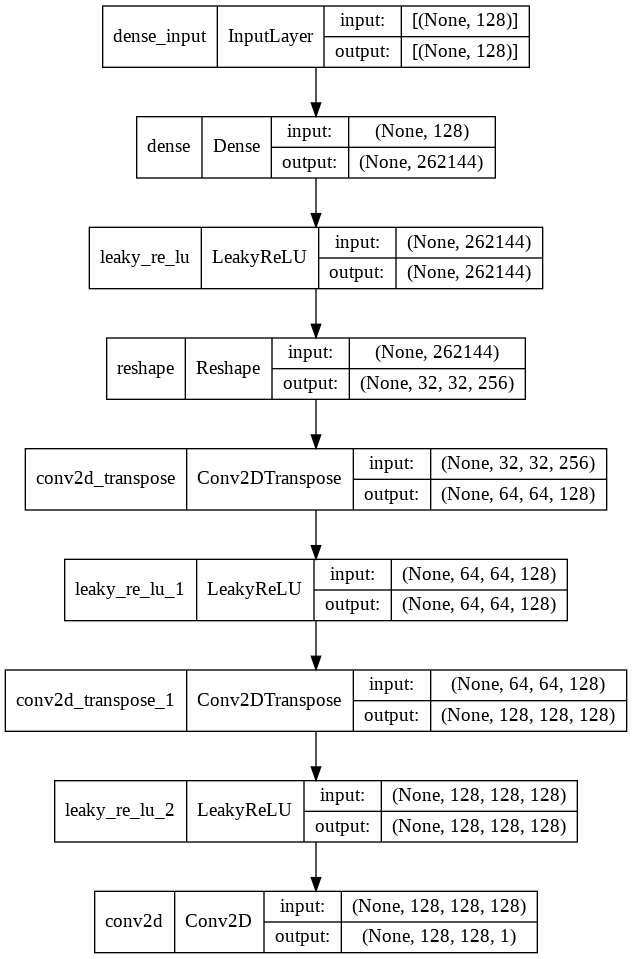

In [4]:
model=create_generator_cgan()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
a=create_generator_cgan()
a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 262144)            33816576  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 262144)            0         
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 128)      524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 128, 128, 128)    262272    
 ranspose)                                            

In [6]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [7]:
dis=create_discriminator_cgan()

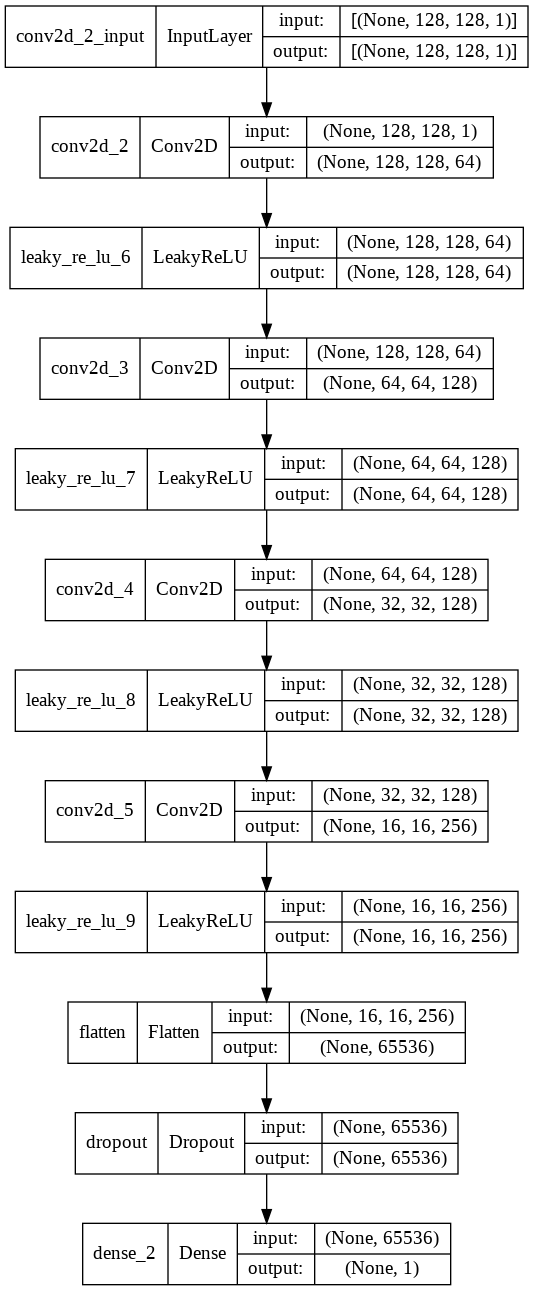

In [8]:
plot_model(dis, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

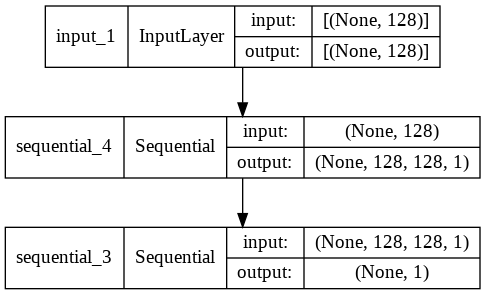

In [10]:
plot_model(gan, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**DATA LOADING**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
x=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended flair/flair.npy')

In [13]:
image2D = []
#mask2D = []
for i in range(195):
  for j in range(128):
    
    image2D.append(x[i,:,:,j])
    #mask2D.append(y[i,:,:,j])
x = np.array(image2D)
#y = np.array(mask2D)

In [14]:
x.shape

(24960, 128, 128)

In [15]:
x_train = np.expand_dims(x, axis = 3)

In [16]:
x_train.shape

(24960, 128, 128, 1)

In [17]:
import matplotlib.pyplot as plt
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)))    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [18]:
saved_model_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/full model'
saved_model_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator'
saved_model_discrimator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/discrimantor'

In [19]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
      
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)
        
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        

         
        if epoch==70:
          generator.save(saved_model_generator)
          gan.save(saved_model_gan)
          discriminator.save(saved_model_discrimator)


    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/full model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/discrimantor/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/full model/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/discrimantor/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 70/generator/assets
INFO:tensorflow:Assets wri

KeyboardInterrupt: ignored

In [ ]:
path_discrim='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/discrimator'
path_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/generator'
path_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/full model'

In [ ]:
generator.save(path_generator)
gan.save(path_gan)
discriminator.save(path_discrim)